In [3]:
import pandas as pd
from src.utils import MySQLAgent
# from plot_tools import cat_value_count_bar_plot, num_value_count_bar_plot
import json

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

### Helper functions

In [4]:
def cat_value_count_bar_plot(df, column, color, title, xlabel, y_label):
    # Calculate the distribution of 'is_improve'
    distribution = df[column].value_counts()

    # Create a bar plot
    plt.figure(figsize=(6, 4))
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()


In [8]:
def num_value_count_bar_plot(df, column, color, title, xlabel, ylabel):
    df[column] = df[column].astype('int')
    distribution = df[column].sort_values().value_counts(sort=False)  # Sort the values by index

    # Create a bar plot
    plt.figure(figsize=(6, 4))  # Adjust figure size as needed
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()

In [5]:
def read_config(path):
    try:
        with open(path, 'r') as file:
            configs = json.load(file)

        return configs
    except FileNotFoundError:
        print(f"The file {path} was not found.")
    except json.JSONDecodeError:
        print(f"Error decoding JSON from the file {path}.")

In [6]:
configs = read_config(path="./conn/connections.json")
job_configs = configs["CREDITREPORT"]['VM1_mysql_conn_info']
sql_agent = MySQLAgent(job_configs)

In [11]:
query = """
    select * from company
"""
df_company = sql_agent.read_table(query=query)
df_company.head()

,business_accounting_no,company_name,internal_id,query_name
0,00700019,國昌綜合工廠有限公司,K7913,None
1,00713181,華聯食品工業股份有限公司,J5984,None
2,00784930,建寶食品股份有限公司,K4395,None
3,00966299,財團法人台北市瑠公農業產銷基金會,K9232,None
4,01055919,新光醫療財團法人,K1282,None


In [12]:
i = 0
# company = df_company.iloc[i]
company = df_company[df_company['business_accounting_no'] == '27450696']
company_account = company.business_accounting_no.values[0]
company_name = company.company_name.values[0]
internal_id = company.internal_id.values[0]
company_account

'27450696'

In [13]:
company

,business_accounting_no,company_name,internal_id,query_name
3454,27450696,日月千禧酒店股份有限公司,K3844,None


#### companyinfo01

- 企業狀態
- 地址關聯
- 資本額(Captial_Stock_Amount)
- 最近更新日期

In [14]:
try:
    query = f"""
        select * from companyinfo01
        where Business_Accounting_No = {company_account}
    """
    companyinfo01 = sql_agent.read_table(query=query)
    companyinfo01.head()
except Exception as e:
    print("An error occurred:", e)


In [15]:
companyinfo01

,Business_Accounting_NO,Company_Status_Desc,Company_Name,Capital_Stock_Amount,Paid_In_Capital_Amount,Responsible_Name,Company_Location,Register_Organization_Desc,Company_Setup_Date,Change_Of_Approval_Data,Revoke_App_Date,Case_Status,Case_Status_Desc,Sus_App_Date,Sus_Beg_Date,Sus_End_Date,CreateTime,UpdateTime
0,27450696,核准設立,日月千禧酒店股份有限公司,800000000,700000000,張重興,臺中市西屯區市政路77號,經濟部商業司,0930923,1110428,,,,,,,2024-01-29 06:57:38,2024-03-08 20:02:34


In [16]:
# 公司狀態
company_status = companyinfo01['Company_Status_Desc'].values[0]

# 地址關聯 - neo4j

# 資本額
company_captial = companyinfo01['Capital_Stock_Amount'].values[0]

#### EPA

In [17]:
query = f"""
select * from epa_ems_p_46
where Business_Accounting_No = {company_account}
"""
df_epa = sql_agent.read_table(query=query)
df_epa.columns = df_epa.columns.str.lower()
df_epa.head()

,business_accounting_no,ems_no,fac_name,county_name,document_no,transgress_date,transgress_law,penalty_money,penalty_date,ispetition,...,is_improve,inspection_datetime_s,penaltykind,isimportant,paymentstate,isreminder,isadmincourt,isreducemoney,createtime,updatetime
0,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-101-110001,2012-08-28,環境影響評估法第17條,300000,2012-11-16,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
1,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-107-010001,2017-11-10,環境影響評估法第17條,300000,2018-01-02,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
2,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-060013,2013-05-14,空氣污染防制法第20條第1款,100000,2013-06-17,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
3,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-110014,2013-09-16,空氣污染防制法第20條第1項,200000,2013-11-11,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
4,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,41-101-100702,2012-08-15,廢棄物清理法第27條第2款,4500,2012-10-11,0,...,已改善完成,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17


In [18]:
if df_epa.size == 0:
    print(f'{company_name} 沒有環保署裁處紀錄。')

In [19]:
df_epa[['document_no', 'is_improve']]

,document_no,is_improve
0,10-101-110001,不須改善
1,10-107-010001,不須改善
2,20-102-060013,已改善完成
3,20-102-110014,已改善完成
4,41-101-100702,已改善完成


In [20]:
df_epa.sort_values('penalty_date', ascending=True)

,business_accounting_no,ems_no,fac_name,county_name,document_no,transgress_date,transgress_law,penalty_money,penalty_date,ispetition,...,is_improve,inspection_datetime_s,penaltykind,isimportant,paymentstate,isreminder,isadmincourt,isreducemoney,createtime,updatetime
4,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,41-101-100702,2012-08-15,廢棄物清理法第27條第2款,4500,2012-10-11,0,...,已改善完成,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
0,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-101-110001,2012-08-28,環境影響評估法第17條,300000,2012-11-16,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
2,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-060013,2013-05-14,空氣污染防制法第20條第1款,100000,2013-06-17,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
3,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-110014,2013-09-16,空氣污染防制法第20條第1項,200000,2013-11-11,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
1,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-107-010001,2017-11-10,環境影響評估法第17條,300000,2018-01-02,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17


In [21]:
# 共有幾筆紀錄
row_count = df_epa.shape[0]

# 最高裁處金額
max_penalty_money = df_epa['penalty_money'].max()

# 近期裁處金額
df_epa['penalty_date'] = pd.to_datetime(df_epa['penalty_date'])
latest_penalty_money = df_epa.loc[df_epa['penalty_date'] == df_epa['penalty_date'].max(), 'penalty_money'].values[0]


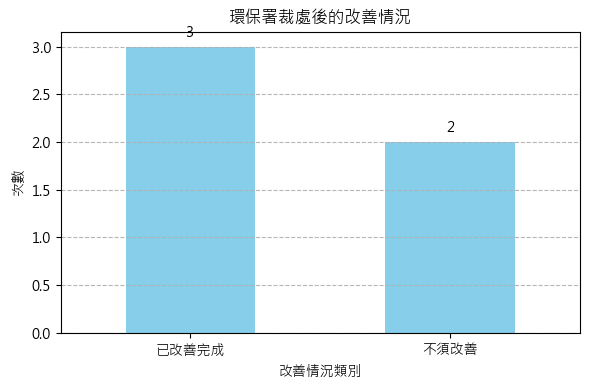

In [22]:
# is_improve分布
cat_value_count_bar_plot(df_epa, 'is_improve', 'skyblue', '環保署裁處後的改善情況', '改善情況類別', '次數')

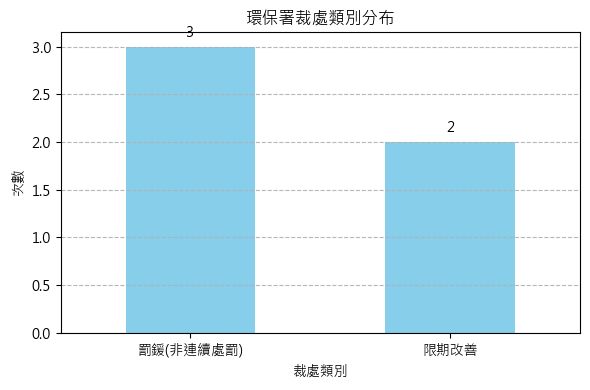

In [23]:
# penaltykind分布
cat_value_count_bar_plot(df_epa, 'penaltykind', 'skyblue', '環保署裁處類別分布', '裁處類別', '次數')

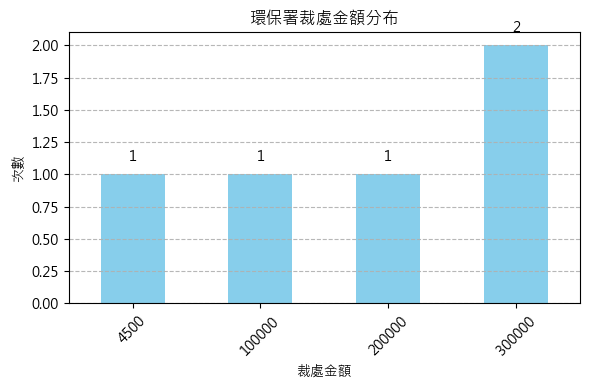

In [24]:
# 裁處金額分布
num_value_count_bar_plot(df_epa, 'penalty_money', 'skyblue', '環保署裁處金額分布', '裁處金額', '次數')

In [25]:
EPA_report = f"""
公司名稱: {company_name}
統一編號: {company_account}

報告類別: 環保署汙染紀錄

裁處總次數: {row_count}
"""

EPA_report

'\n公司名稱: 日月千禧酒店股份有限公司\n統一編號: 27450696\n\n報告類別: 環保署汙染紀錄\n\n裁處總次數: 5\n'